Ideas for performance improvement:
- Static Tipying: NO!
- Numba: NoPyton, Parallelize, TypeSpecification, Nogil?
- For Random Numbers two function (Cuda vs NoCuda)

In [240]:
from numba import jit
from numpy import zeros, arange, float32, sqrt, int64
import numpy as np
import time
import os
import _pickle as pickle
import pathos.multiprocessing as multiprocessing
from pathos.pools import ProcessPool
import pathos.profile as pr
import matplotlib.pyplot as plt

In [302]:
n_sim = 10
theta = np.ones((n_sim,5,1)) * 100 # n_sim x theta
x = zeros((n_sim,1), dtype = float32)
t = theta[:,0]
theta = np.array([2e4,2e-2,3e-3,5e-2,3]*10)
theta = theta.reshape((10,5,1))

In [261]:
dt = 1e-6# The time step size for the simulation. This is the amount of time that passes in the model for each step of the simulation
Sample_frequency = 1e-6 # The sampling frequency. This is the number of samples that are recorded per unit time
DeltaT = 1e-2 # The sampling period. This is the amount of time that passes in the model between each sample that is recorded
TotalT = 3 # The total time for the simulation. This is the total amount of time that the simulation is intended to represent

In [325]:
# Limits for the parameters
prior_limits = {
    "mu_y": [1e4, 140e4],
    "k_y": [1.5e-2, 30e-2],
    "k_int": [1e-3, 6e-3],
    "tau": [2e-2, 20e-2],
    "eps": [0.5, 6],
}
#theta = np.array([np.random.uniform(prior_limits[i][0], prior_limits[i][1], size=(10, 1)) for i in prior_limits]).reshape((10,5,1))
theta = np.array([np.random.uniform(prior_limits[i][0], prior_limits[i][1], size=(10, 1)) for i in prior_limits])
theta.shape

(5, 10, 1)

In [328]:
@jit(nopython = True)
def Simulator_noGPU(dt, DeltaT, TotalT, theta, transient_time = 0,  i_state = None, mu_x = 2.8e4, k_x = 6e-3, kbT = 3.8, debug = False):
    
    
    time_steps_amount = int64(TotalT/dt) # Number of steps
    sampled_point_amount = int64((TotalT - transient_time)/DeltaT) # Number of sampled points
    sampling_delta_time_steps = int64(DeltaT/dt) # Number of steps between samples
    transient_time_steps = int64(transient_time/dt)
    n_sim = theta.shape[1]

    if debug:
        print("Time steps amount: ", time_steps_amount)
        print("Sampled point amount: ",sampled_point_amount)
        print("Sampling delta time steps: ", sampling_delta_time_steps)
        print("Transient time steps: ", transient_time_steps)
        print("Number of simulations: ", n_sim)
        print("You are currently using ", theta.shape[1], " free parameters")
    
    
    mu_y = theta[0]
    k_y = theta[1]
    k_int = theta[2]
    tau = theta[3]
    eps = theta[4]
    D_x = kbT * mu_x
    D_y = kbT * mu_y
    print("mu_y: ", mu_y[0])
    print("k_y: ", k_y[0])
    print("k_int: ", k_int[0])
    print("tau: ", tau[0])
    print("eps: ", eps[0])
    print("D_x: ", D_x)
    print("D_y: ", D_y[0])
    
    
    if theta.shape[1] != n_sim:
        raise Exception("Something went wrong with the detection of the number of simulations")
    
    if transient_time > TotalT:
        raise Exception("Transient time is greater than Total Time")
    
    # Handle initial state
    if i_state is None:
        x = zeros((n_sim,1), dtype = float32)
        y = zeros((n_sim,1), dtype = float32)
        f = zeros((n_sim,1), dtype = float32)
    else:
        if x.shape == (n_sim,1) or y.shape == (n_sim,1) or f.shape == (n_sim,1):
            raise Exception("Initial state has wrong shape, each should be (n_sim,1)")
        x, y, f = i_state
    
    # Initialize x_trace array
    x_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    f_trace = zeros((n_sim, sampled_point_amount), dtype = float32)
    y_trace = zeros((n_sim, sampled_point_amount), dtype = float32)

    sampling_counter = int64(1)
    
    # POSSIBLE OPTIM: You could overwrite the last used row of the trace to save memory and not create a proxy array
    
    # TRADEOFF: Memory vs Speed. We can generate the numbers here, or before. Maybe the time is the same... Should test
    
    # CHECK: Benchmark the version with the explicit dx, dy, df and the one with the x, y, f arrays with the calculation in the assigment
    
    # Initialize intermediate step
    
    x_tilde = zeros((n_sim,1), dtype = float32)
    y_tilde = zeros((n_sim,1), dtype = float32)
    f_tilde = zeros((n_sim,1), dtype = float32)
    
    # Pre-compute constant
    sqrt_2mu_x_D_x_dt = sqrt(2*mu_x*D_x*dt)
    sqrt_2mu_y_D_y_dt = sqrt(2*mu_y*D_y*dt)
    sqrt_2eps2_dt_tau = sqrt(2*eps**2*dt/tau)
    
    mu_x_dt = mu_x*dt
    mu_y_dt = mu_y*dt
    tau_dt = dt/tau
    
    
    for t in arange(time_steps_amount - 1):
        # Virtual time-step
        x_tilde[:,] =  x[:,] +mu_x*(- k_x * x[:,] + k_int*y[:,])*dt             +  sqrt_2mu_x_D_x_dt * np.random.randn(n_sim,1)
        y_tilde[:,] =  y[:,] + mu_y*(-k_y*y[:,] + k_int*x[:,] + f[:,])*dt       +  sqrt_2mu_y_D_y_dt * np.random.randn(n_sim,1)
        f_tilde[:,] =  f[:,] +-(f[:,]/tau)*dt                                   +  sqrt_2eps2_dt_tau * np.random.randn(n_sim,1)
        
        # Real time-step  x + (A + B)/2 = xt -A/2 + B/2 = xt + (B-A)/2
        # x + A = xt
        x[:,] = x_tilde[:,] + (  - mu_x_dt*(- k_x * x[:,] + k_int*y[:,])      + mu_x_dt*(- k_x * x_tilde[:,] + k_int*y_tilde[:,])           ) / 2
        y[:,] = y_tilde[:,] + (  - mu_x_dt*(-k_y*y[:,] + k_int*x[:,] + f[:,]) + mu_y_dt*(-k_y*y_tilde[:,] + k_int*x_tilde[:,] + f_tilde[:,])) / 2
        f[:,] = f_tilde[:,] + (  - (-f[:,])*tau_dt                            + (-f_tilde[:,])*tau_dt                                       ) / 2
        
        # Old Euler Code, keep for reference
        # x[:,] = x[:,] + mu_x*(- k_x * x[:,] + k_int*y[:,])*dt      + sqrt(2*mu_x*D_x*dt)   * np.random.randn(n_sim,1)
        # y[:,] = y[:,] + mu_y*(-k_y*y[:,] + k_int*x[:,] + f[:,])*dt + sqrt(2*mu_y*D_y*dt)   * np.random.randn(n_sim,1)
        # f[:,] = f[:,] + -(f[:,]/tau)*dt                            + sqrt(2*eps**2*dt/tau) * np.random.randn(n_sim,1)

        sampling_counter = sampling_counter + 1
        if sampling_counter == sampling_delta_time_steps:
            sampling_counter = int64(1)
            if t >= transient_time_steps:
                x_trace[:, int((t - transient_time_steps)/sampling_delta_time_steps)] = x[:,0]
                f_trace[:, int((t - transient_time_steps)/sampling_delta_time_steps)] = f[:,0]
                y_trace[:, int((t - transient_time_steps)/sampling_delta_time_steps)] = y[:,0]

            

    return x_trace, f_trace, y_trace # Check if this is right

In [329]:
x, y, f = Simulator_noGPU(dt, DeltaT, TotalT, theta)

mu_y:  [947241.4414786]
k_y:  [0.13327134]
k_int:  [0.00140679]
tau:  [0.18834366]
eps:  [2.25911364]
D_x:  106400.0
D_y:  [3599517.4776187]


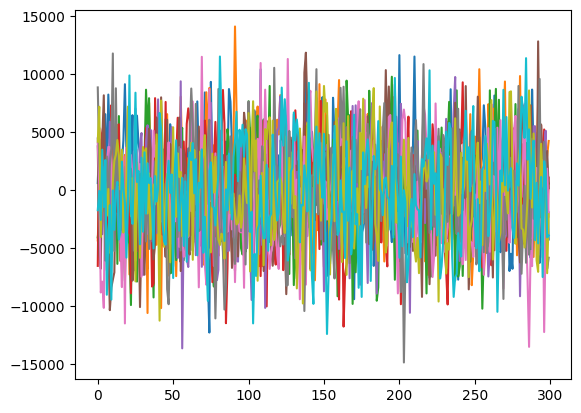

In [332]:
x[0]
plt.plot(x.T)

In [233]:
np.array(theta).reshape((10,9,1))

array([[[1.5e+04],
        [1.5e+04],
        [1.5e+04],
        [1.5e+04],
        [1.5e+04],
        [1.5e+04],
        [1.5e+04],
        [1.5e+04],
        [1.5e+04]],

       [[1.5e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04]],

       [[1.0e+04],
        [1.0e+04],
        [3.0e-03],
        [3.0e-03],
        [3.0e-03],
        [3.0e-03],
        [3.0e-03],
        [3.0e-03],
        [3.0e-03]],

       [[3.0e-03],
        [3.0e-03],
        [3.0e-03],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02]],

       [[1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03]],

       [[1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [2.0e-02],
        [2.0e-02],
  

In [238]:
batch_size = 10
np.array([np.random.uniform(prior_limits[i][0], prior_limits[i][0], size=(batch_size, 1)) for i in prior_limits]).reshape((batch_size,5,1))


array([[[1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04]],

       [[1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04],
        [1.0e+04]],

       [[1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02]],

       [[1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02],
        [1.5e-02]],

       [[1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03]],

       [[1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03],
        [1.0e-03]],

       [[2.0e-02],
        [2.0e-02],
        [2.0e-02],
        [2.0e-02],
        [2.0e-02]],

       [[2.0e-02],
        [2.0e-02],
        [2.0e-02],
        [2.0e-02],
        [2.0e-02]],

       [[5.0e-01],
        [5.0e-01],
        [5.0e-01],
        [5.0e-01],
        [5.0e-01]],

       [[5.0e-01],
        [5.0e-01],
        [5.0e-01],
        [5.0e-01],
        [5.0e-01]]])